In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns

from utils.conn_data import load_pickle
from utils.diagnostics import compute_summary_statistics

plt.style.use('ggplot')

In [2]:
inputs_path = os.path.join(os.getcwd(), "data", "inputs")
outputs_path = os.path.join(os.getcwd(), "data", "outputs")
forecast_input = "wrds_etf_returns"
memory_input = "fredmd_transf"
vol_target = 0.15
portfolio_methods = [
    "naive",
    "mvo",
    "bl",
    "linear-ridge",
]

In [3]:
# load memory data and preprocess
memory_data = pd.read_csv(os.path.join(inputs_path, f'{memory_input}.csv'))

## fix dates
memory_data["date"] = pd.to_datetime(memory_data["date"])
memory_data = memory_data.set_index("date")
memory_data = memory_data.astype(float)

# fill missing values
memory_data = memory_data.interpolate(method='linear', limit_direction='forward', axis=0)
memory_data = memory_data.ffill()
memory_data = memory_data.bfill()

## compute moving average
memory_data = memory_data.rolling(window=12).mean()

## drop missing values
memory_data = memory_data.dropna()

returns = pd.read_csv(os.path.join(inputs_path, f'{forecast_input}.csv'))
returns = returns[[col for col in returns.columns if "t+1" not in col]]

## fix dates
returns["date"] = pd.to_datetime(returns["date"])
returns["date"] = returns["date"] #+ pd.DateOffset(months=1)
returns = returns.set_index("date")
memory_data = memory_data.astype(float)

## resample and match memory data dates
returns = returns.resample("MS").last().ffill()
returns = pd.merge(returns, memory_data[[memory_data.columns[0]]], left_index=True, right_index=True).drop(memory_data.columns[0], axis=1)

## drop missing values
returns = returns.dropna()

In [4]:
import numpy as np
import pandas as pd

data_factors = pd.read_csv('data/inputs/fredmd_factors_raw.csv')
transformation_codes = data_factors.iloc[0]
data_factors = data_factors.drop(0)
transformation_codes = transformation_codes.to_dict()
del transformation_codes['sasdate']

small = 1e-6
for column in data_factors.columns:
    if column in transformation_codes:
        match int(transformation_codes[column]):
            case 1:
                data_factors[column] = data_factors[column]

            case 2: # First difference: x(t)-x(t-1)
                data_factors[column] = data_factors[column].diff()

            case 3: # Second difference: (x(t)-x(t-1))-(x(t-1)-x(t-2))
                data_factors[column] = data_factors[column].diff().diff()

            case 4: # Natural log: ln(x)
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)

            case 5: # First difference of natural log: ln(x)-ln(x-1)
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)
                data_factors[column] = data_factors[column].diff()

            case 6: # Second difference of natural log: (ln(x)-ln(x-1))-(ln(x-1)-ln(x-2))
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)
                data_factors[column] = data_factors[column].diff().diff()

            case 7: # First difference of percent change: (x(t)/x(t-1)-1)-(x(t-1)/x(t-2)-1)
                data_factors[column] = data_factors[column].pct_change()
                data_factors[column] = data_factors[column].diff()

data_factors = data_factors.drop([1, 2]).reset_index(drop=True)

data_factors = data_factors.ffill()
data_factors = data_factors.fillna(0.0)

data_factors['sasdate'] = pd.to_datetime(data_factors['sasdate'], format='%m/%d/%Y')
data_factors = data_factors.rename(columns={'sasdate': 'date'})
data_factors = data_factors.set_index('date')


from sklearn.decomposition import PCA
import matplotlib.pyplot as plot

df_normalized = data_factors

# You must normalize the data before applying the fit method
df_normalized=(df_normalized - df_normalized.mean()) / df_normalized.std()
pca = PCA(n_components=df_normalized.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df_normalized.columns)
print(loadings)

DESIRE_EXPLAINED_VARIANCE = 0.95
total_explained_variance = 0.0
for i, x in enumerate(pca.explained_variance_ratio_):
    total_explained_variance += x
    if total_explained_variance >= DESIRE_EXPLAINED_VARIANCE:
        print(f"Number of components to explain {DESIRE_EXPLAINED_VARIANCE * 100}% variance: {i+1}")
        break
n_components = i+1

# Use the top n components to transform the data
pca = PCA(n_components=df_normalized.shape[1])
pca.fit(df_normalized)
df_transformed = pd.DataFrame(pca.transform(df_normalized),
columns=['PC%s' % _ for _ in range(df_normalized.shape[1])],
index=df_normalized.index)
df_transformed = df_transformed[['PC%s' % _ for _ in range(n_components)]]

print(df_transformed)

memory_data = df_transformed

                      PC0       PC1       PC2       PC3       PC4       PC5  \
RPI             -0.032678 -0.047984 -0.000752  0.025343  0.063781  0.045892   
W875RX1          0.112550 -0.068211  0.038119 -0.032999  0.006149 -0.006541   
DPCERA3M086SBEA  0.146550  0.027131  0.060616 -0.042417 -0.018647  0.143320   
CMRMTSPLx        0.135673 -0.008126  0.053135 -0.014012  0.024570  0.093309   
RETAILx          0.127633  0.065554  0.019088 -0.035344  0.000766  0.146614   
...                   ...       ...       ...       ...       ...       ...   
UMCSENTx         0.037855  0.012142  0.030014  0.014400 -0.012411  0.098975   
DTCOLNVHFNM      0.002451  0.009939 -0.011267  0.016205 -0.015283  0.058104   
DTCTHFNM         0.006255  0.013653 -0.012419  0.018355 -0.013001  0.032122   
INVEST           0.015517  0.016652  0.007961 -0.011221 -0.015233 -0.019285   
VIXCLSx         -0.052323  0.001555 -0.009238 -0.039914 -0.001340  0.121704   

                      PC6       PC7       PC8      

In [5]:
# get regimes
#memory_dir_name = "kmeans_elbow"
memory_dir_name = 'kmeans'
memory_results_path = os.path.join("data", "inputs", "memory", memory_dir_name, "results.pkl")
memory_results = pd.read_pickle(memory_results_path)
regimes = memory_results["regimes"]
centroids = memory_results["centroids"]
regimes_probs = memory_results["regimes_probs"]

In [6]:
pd.DataFrame(memory_data.columns)

,0
0,PC0
1,PC1
2,PC2
3,PC3
4,PC4
...,...
56,PC56
57,PC57
58,PC58
59,PC59


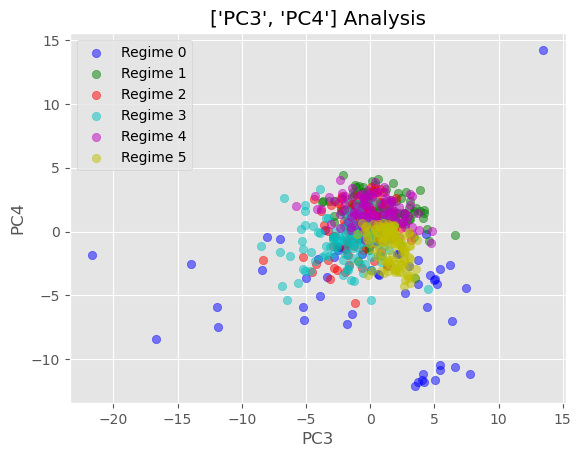

In [7]:
etfs = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
macro_vars = ['PC3', 'PC4']

plt.clf()
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i in range(6):
    plt.scatter(memory_data[macro_vars[0]][:-1][regimes['cluster_step697'] == i], memory_data[macro_vars[1]][:-1][regimes['cluster_step697'] == i], c=colors[i], label=f"Regime {i}", alpha=0.5)
plt.title(f"{macro_vars} Analysis")
plt.xlabel(macro_vars[0])
plt.ylabel(macro_vars[1])
plt.legend()
plt.show()

In [8]:
# etfs = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
# macro_var = 'PC0'

# for etf in etfs:
#     plt.clf()
#     colors = ['b', 'g', 'r', 'c', 'm', 'y']
#     for i in range(6):
#         plt.scatter(memory_data[-275:][macro_var][regimes[-275:]['cluster_step697'] == i],
#                     returns[etf][regimes[-275:]['cluster_step697'] == i], c=colors[i], label=f"Regime {i}", alpha=0.5)
#     plt.title(f"{etf} / {macro_var} Analysis")
#     plt.xlabel(macro_var)
#     plt.ylabel(etf + " Returns")
#     plt.legend()
#     plt.show()

In [9]:
all_portfolio_returns = []
colors = ['r', 'b', 'g', 'y', 'm', 'c', 'k']
line_types = ['-', '--', '-.', ':']
styles = ['m', 'c']
style_map = {}
for method in portfolio_methods:
    print(method)
    cur_color = colors.pop(0)
    dirs = os.listdir(os.path.join(outputs_path, method))

    for i, dir in enumerate(dirs):
        cur_line_type = line_types[i % len(line_types)]
        styles.append(f"{cur_color}{cur_line_type}")
        style_map[method + dir.split('/')[-1][7:-4]] = f"{cur_color}{cur_line_type}"
        print(method, dir)

        try:
            results = load_pickle(os.path.join(outputs_path, method, dir))
        except:
            print(method, dir)
            continue

        # get forecasts
        forecasts = results['forecasts']
        forecasts.index = pd.to_datetime(forecasts.index)
        forecasts.index.name = "date"

        # check which dataframe haas the smallest number of rows and match dates
        if len(forecasts) < len(returns):
            returns = returns.loc[forecasts.index[0]:forecasts.index[-1]]
        else:
            forecasts = forecasts.loc[returns.index[0]:returns.index[-1]]

        # match columns
        forecasts = forecasts[returns.columns]

        # portfolio returns
        portfolio_returns = forecasts.multiply(returns, axis=0)

        model_tag = dir.split('.')[0][8:]
        #long_only_tag = dir.split('.')[0].split('_')[1]
        #num_assets_tag = dir.split('.')[0].split('_')[2]
        portfolio_returns["models"] = f"{method}_{model_tag}"

        all_portfolio_returns.append(portfolio_returns.reset_index().melt(["models", "date"]))
all_portfolio_returns_df = pd.concat(all_portfolio_returns)

naive
naive results_mx_4_rand.pkl
naive results_lns_3_rand.pkl
naive results_lns_2_rand.pkl
naive results_mx_4.pkl
naive results_lo_4_rand.pkl
naive results_mx_2.pkl
naive results_mx_3.pkl
naive results_lns_4.pkl
naive results_lo_2.pkl
naive results_lo_2_rand.pkl
naive results_lo_3_rand.pkl
naive results_lo_3.pkl
naive results_mx_2_rand.pkl
naive results_mx_3_rand.pkl
naive results_lns_3.pkl
naive results_lns_4_rand.pkl
naive results_lns_2.pkl
naive results_lo_4.pkl
naive results_los_2_rand.pkl
naive results_los_3_rand.pkl
naive results_los_4.pkl
naive results_los_4_rand.pkl
naive results_los_2.pkl
naive results_los_3.pkl
mvo
mvo results_lns_4.pkl
mvo results_lo_2.pkl
mvo results_lo_3.pkl
mvo results_lns_3.pkl
mvo results_lns_2.pkl
mvo results_lo_4.pkl
bl
bl results_lns_3_rand.pkl
bl results_lns_2_rand.pkl
bl results_lo_4_rand.pkl
bl results_lns_4.pkl
bl results_lo_2.pkl
bl results_lo_2_rand.pkl
bl results_lo_3_rand.pkl
bl results_lo_3.pkl
bl results_lns_3.pkl
bl results_lns_4_rand.pkl

In [10]:
%config InlineBackend.figure_format = 'retina'
equal_weight_cumm_returns = pd.DataFrame(returns.mean(axis=1), columns=["ew"])
spy_cumm_returns = pd.DataFrame(pd.DataFrame(returns['SPY'], columns=["SPY"]).sum(axis=1), columns=["spy"])
concat_list = [equal_weight_cumm_returns, spy_cumm_returns]

model_list = all_portfolio_returns_df["models"].unique()
model_list = [
    'naive_lns_2',
    'naive_mx_2',
    'naive_los_2',
    'naive_lo_2',
    'naive_lns_3',
    'naive_mx_3',
    'naive_los_3',
    'naive_lo_3',
    'naive_mx_4',
    'naive_lns_4',
    'naive_los_4',
    'naive_lo_4',

    'naive_lns_2_rand',
    'naive_mx_2_rand',
    'naive_los_2_rand',
    'naive_lo_2_rand',
    'naive_lns_3_rand',
    'naive_mx_3_rand',
    'naive_los_3_rand',
    'naive_lo_3_rand',
    'naive_lns_4_rand',
    'naive_mx_4_rand',
    'naive_los_4_rand',
    'naive_lo_4_rand',

    'mvo_lns_2',
    'mvo_lo_2',
    'mvo_lns_3',
    'mvo_lo_3',
    'mvo_lns_4',
    'mvo_lo_4',

    'bl_lns_2',
    'bl_lo_2',
    'bl_lns_3',
    'bl_lo_3',
    'bl_lns_4',
    'bl_lo_4',

    'bl_lns_2_rand',
    'bl_lo_2_rand',
    'bl_lns_3_rand',
    'bl_lo_3_rand',
    'bl_lns_4_rand',
    'bl_lo_4_rand',

    'linear-ridge_lns_2',
    'linear-ridge_mx_2',
    'linear-ridge_los_2',
    'linear-ridge_lo_2',
    'linear-ridge_lns_3',
    'linear-ridge_mx_3',
    'linear-ridge_los_3',
    'linear-ridge_lo_3',
    'linear-ridge_lns_4',
    'linear-ridge_mx_4',
    'linear-ridge_los_4',
    'linear-ridge_lo_4',


    'linear-ridge_lns_2_rand',
    'linear-ridge_mx_2_rand',
    'linear-ridge_los_2_rand',
    'linear-ridge_lo_2_rand',
    'linear-ridge_lns_3_rand',
    'linear-ridge_mx_3_rand',
    'linear-ridge_los_3_rand',
    'linear-ridge_lo_3_rand',
    'linear-ridge_lns_4_rand',
    'linear-ridge_mx_4_rand',
    'linear-ridge_los_4_rand',
    'linear-ridge_lo_4_rand',
]
print(style_map)
styles = ['m', 'c'] + [style_map[model] for model in model_list]
for model in model_list:
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")
    order = tmp_portfolio_returns.cumsum().mean(axis=0).sort_values(ascending=False).index
    # ax = tmp_portfolio_returns.cumsum()[order].plot(figsize=(10, 6), title=f"Individual Asset Cumulative Returns: Model = {model}")
    
    # # Place the legend outside the plot
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # plt.show()

    # add equal weight
    concat_list.append(pd.DataFrame(tmp_portfolio_returns.sum(axis=1), columns=[model]))

{'naive_mx_4_rand': 'r-', 'naive_lns_3_rand': 'r--', 'naive_lns_2_rand': 'r-.', 'naive_mx_4': 'r:', 'naive_lo_4_rand': 'r-', 'naive_mx_2': 'r--', 'naive_mx_3': 'r-.', 'naive_lns_4': 'r:', 'naive_lo_2': 'r-', 'naive_lo_2_rand': 'r--', 'naive_lo_3_rand': 'r-.', 'naive_lo_3': 'r:', 'naive_mx_2_rand': 'r-', 'naive_mx_3_rand': 'r--', 'naive_lns_3': 'r-.', 'naive_lns_4_rand': 'r:', 'naive_lns_2': 'r-', 'naive_lo_4': 'r--', 'naive_los_2_rand': 'r-.', 'naive_los_3_rand': 'r:', 'naive_los_4': 'r-', 'naive_los_4_rand': 'r--', 'naive_los_2': 'r-.', 'naive_los_3': 'r:', 'mvo_lns_4': 'b-', 'mvo_lo_2': 'b--', 'mvo_lo_3': 'b-.', 'mvo_lns_3': 'b:', 'mvo_lns_2': 'b-', 'mvo_lo_4': 'b--', 'bl_lns_3_rand': 'g-', 'bl_lns_2_rand': 'g--', 'bl_lo_4_rand': 'g-.', 'bl_lns_4': 'g:', 'bl_lo_2': 'g-', 'bl_lo_2_rand': 'g--', 'bl_lo_3_rand': 'g-.', 'bl_lo_3': 'g:', 'bl_lns_3': 'g-', 'bl_lns_4_rand': 'g--', 'bl_lns_2': 'g-.', 'bl_lo_4': 'g:', 'linear-ridge_mx_4_rand': 'y-', 'linear-ridge_lns_3_rand': 'y--', 'linear-r

In [11]:
pd.concat(concat_list, axis=1)

,ew,spy,naive_lns_2,naive_mx_2,naive_los_2,naive_lo_2,naive_lns_3,naive_mx_3,naive_los_3,naive_lo_3,...,linear-ridge_los_2_rand,linear-ridge_lo_2_rand,linear-ridge_lns_3_rand,linear-ridge_mx_3_rand,linear-ridge_los_3_rand,linear-ridge_lo_3_rand,linear-ridge_lns_4_rand,linear-ridge_mx_4_rand,linear-ridge_los_4_rand,linear-ridge_lo_4_rand
date,,,,,,,,,,,,,,,,,,,,,
2004-02-01,0.021669,0.013480,-0.033521,0.013591,-0.041577,0.013591,-0.027489,0.013591,-0.032914,0.013591,...,-0.038748,0.000000,-0.028801,0.000000,-0.035631,0.000000,-0.029792,0.000000,-0.031802,0.000000
2004-03-01,-0.013460,-0.013350,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.014827,-0.025749,-0.010899,-0.022864,-0.013710,-0.022864,-0.010412,-0.020612,-0.015436,-0.020612
2004-04-01,-0.014493,-0.019102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.045977,-0.045977,-0.029157,-0.041881,-0.034923,-0.041881,-0.026714,-0.041505,-0.032353,-0.041505
2004-05-01,0.013079,0.016978,0.013639,0.013403,0.013403,0.013403,0.010114,0.010276,0.010276,0.010276,...,-0.034449,-0.005624,-0.029433,-0.005624,-0.030887,-0.005624,-0.025997,-0.005624,-0.028850,-0.005624
2004-06-01,0.024006,0.018295,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.016470,0.016470,0.020564,0.026112,0.026112,0.026112,0.029931,0.033655,0.033655,0.033655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01,0.081214,0.088091,0.069648,0.059989,0.059989,0.059989,0.067145,0.062832,0.062832,0.062832,...,-0.035397,0.037807,-0.028330,0.039645,-0.034225,0.039645,-0.036289,0.039645,-0.038387,0.039645
2022-08-01,-0.028244,-0.041658,0.019181,0.009164,0.009164,0.000000,0.022806,0.012222,0.012222,0.000000,...,-0.027357,-0.027357,-0.030706,-0.035077,-0.035077,-0.035077,-0.029098,-0.040639,-0.040639,-0.040639
2022-09-01,-0.092404,-0.096642,-0.101541,-0.098653,-0.098653,-0.098653,-0.103218,-0.104455,-0.104455,-0.104455,...,0.097412,-0.099631,0.088233,-0.099631,0.106428,-0.099631,0.090265,-0.099631,0.104647,-0.099631


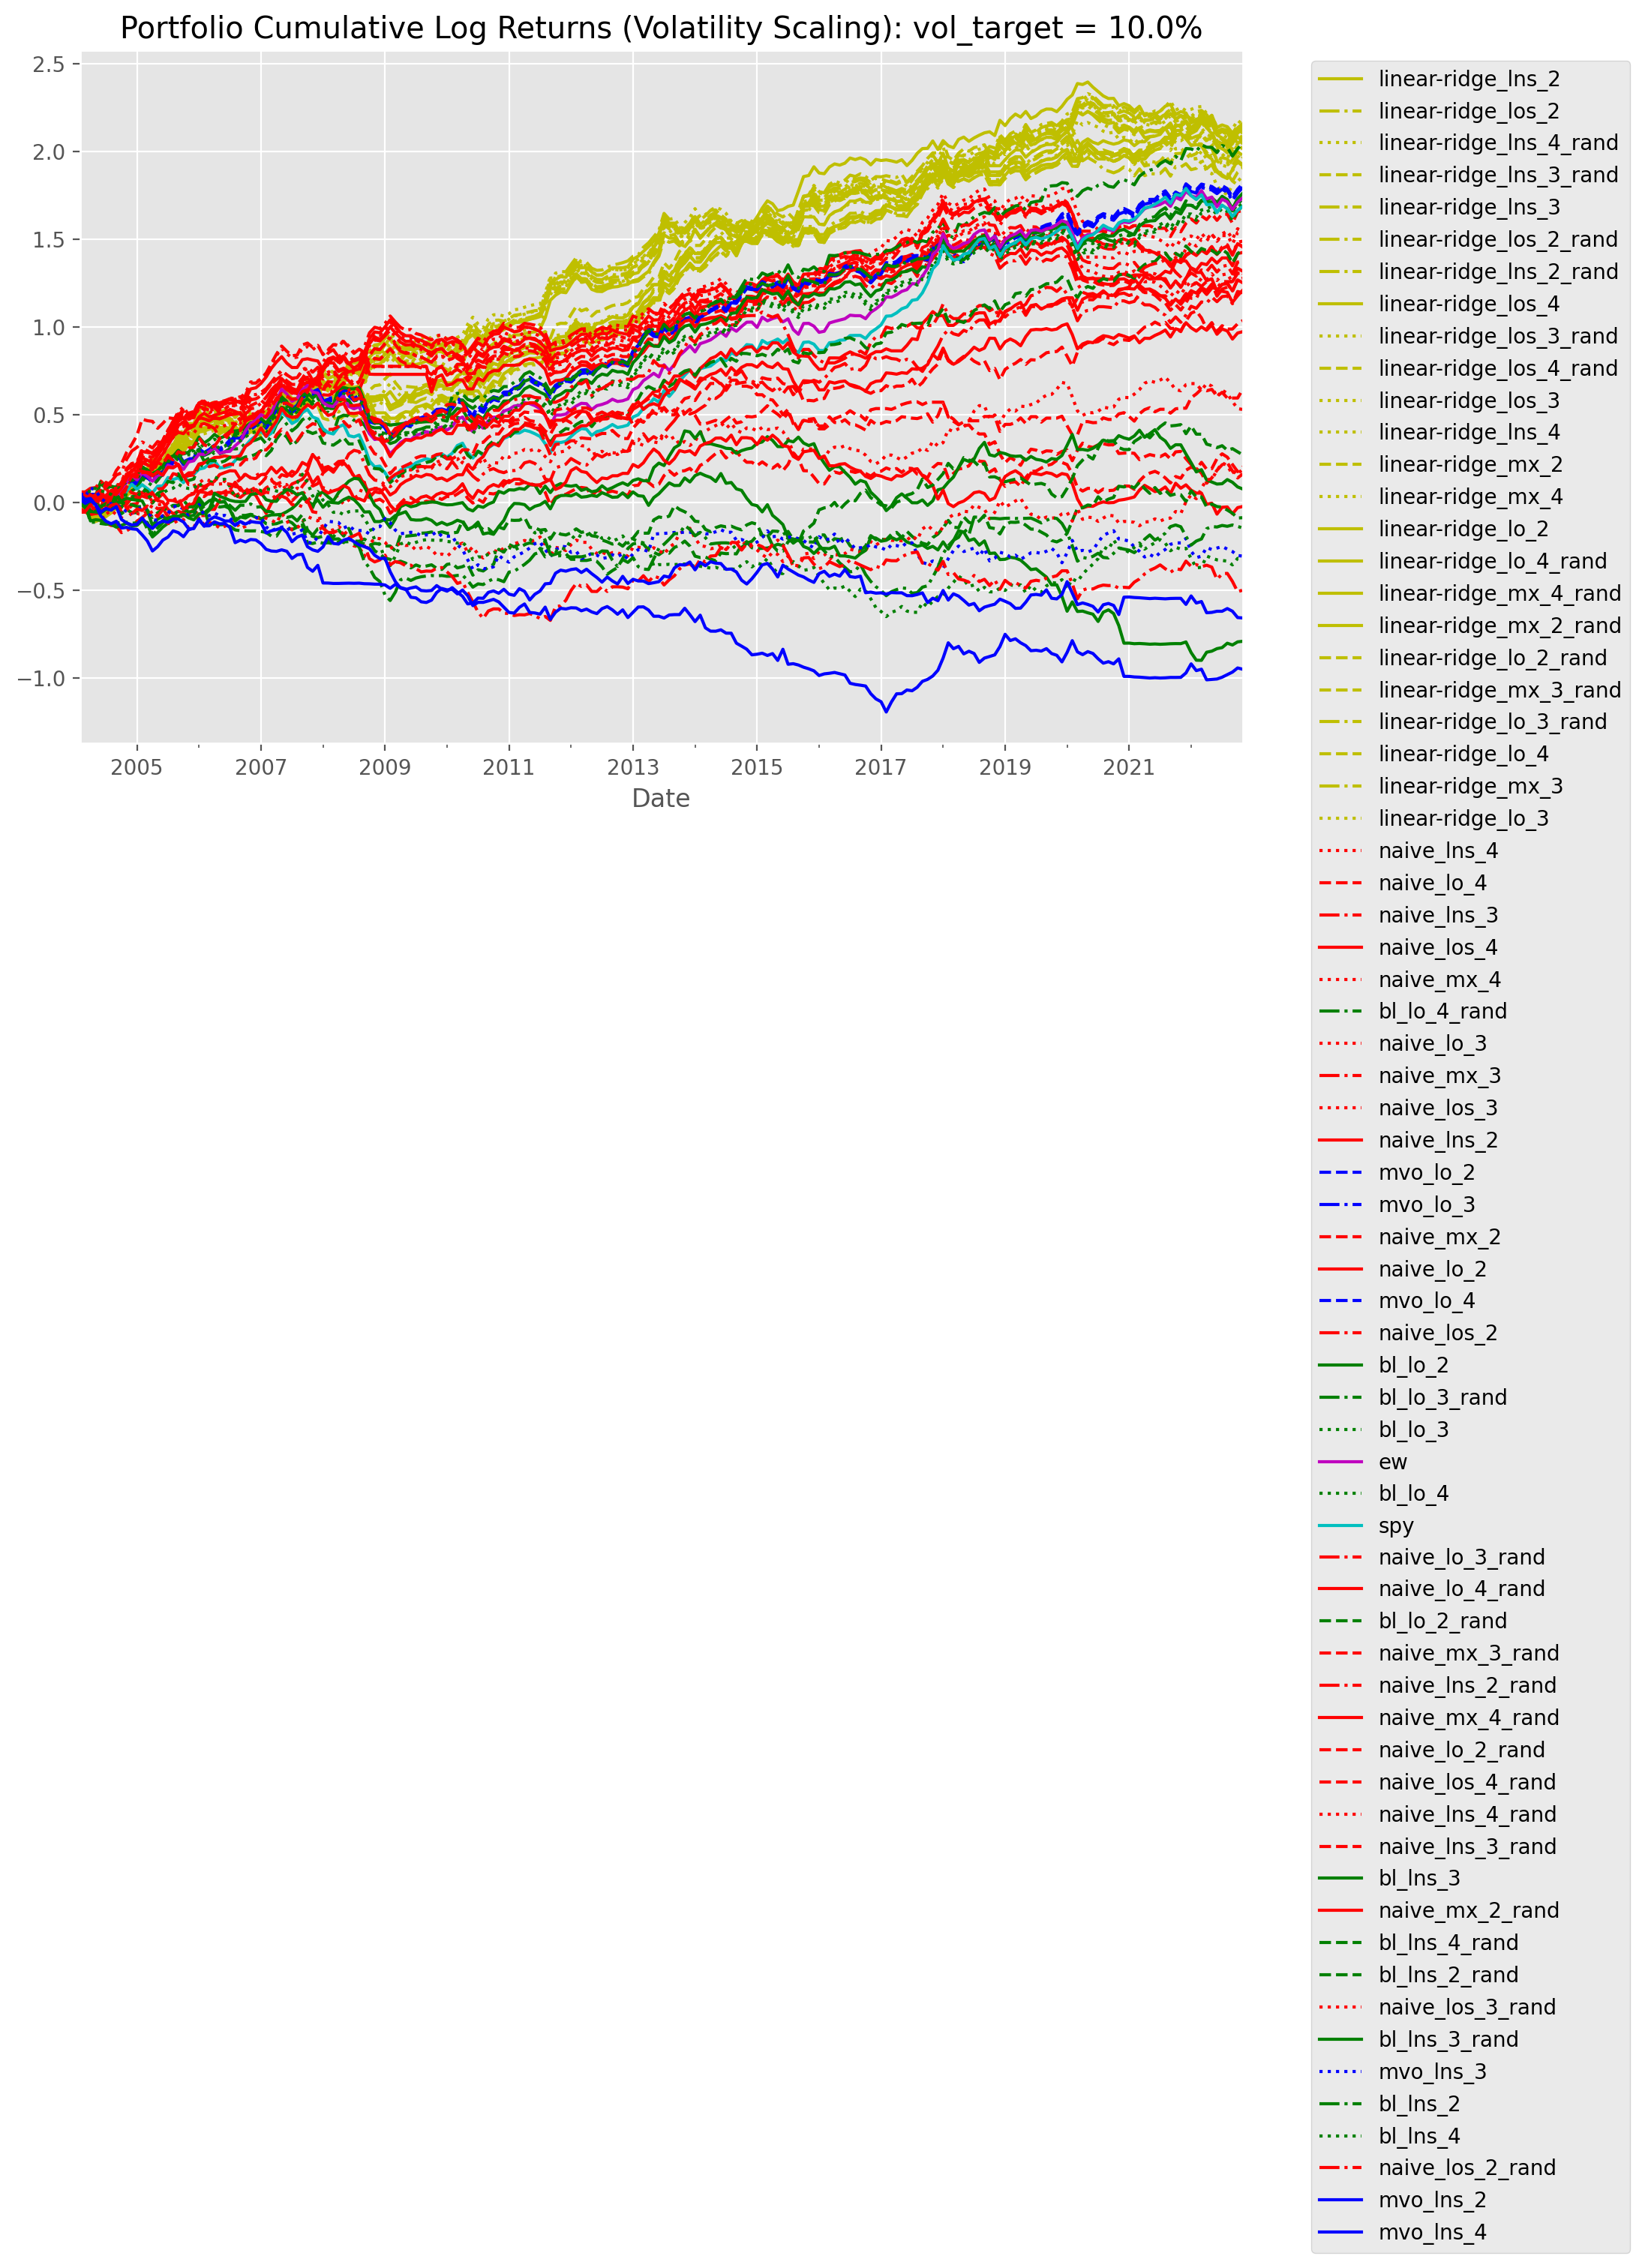

In [12]:
returns = pd.concat(concat_list, axis=1)
cum_returns_plot = returns.cumsum()

# Volatility scaling
vol_target = 0.10
portfolio_vol = vol_target / (returns.rolling(window=12).std().bfill() * np.sqrt(12))
voladj_returns = (returns * portfolio_vol).dropna()
cum_voladj_returns = voladj_returns.cumsum()
order = cum_voladj_returns.mean(axis=0).sort_values(ascending=False).index
order_style = list(cum_voladj_returns.mean(axis=0).argsort())
ax = cum_voladj_returns[order].plot(figsize=(10, 6), style=[styles[x] for x in reversed(order_style)], title=f"Portfolio Cumulative Log Returns (Volatility Scaling): vol_target = {vol_target * 100}%", xlabel="Date")

# Place the legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [13]:
# ew_vol_scale = 10 / (equal_weight_cumm_returns.rolling(window=3).std() * 12 * 100)
# tensor_scaled_equal_weight_cumm_returns = torch.tensor((equal_weight_cumm_returns * ew_vol_scale).dropna().values)
ew_summary_statistics = compute_summary_statistics(torch.tensor(equal_weight_cumm_returns.values))
ew_summary_statistics = pd.DataFrame([ew_summary_statistics], index=["EW"])

all_summary_statistics = []
for model in model_list:
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")

    vol_scale = 10 / (tmp_portfolio_returns.mean(axis=1).rolling(window=3).std() * 12 * 100)
    tensor_tmp_portfolio_returns = torch.tensor((tmp_portfolio_returns.mean(axis=1) * vol_scale).dropna().values)
    summary_statistics = compute_summary_statistics(tensor_tmp_portfolio_returns)
    summary_statistics = pd.DataFrame([summary_statistics], index=[model])

    all_summary_statistics.append(summary_statistics)
all_summary_statistics_df = pd.concat(all_summary_statistics)

all_summary_statistics_df

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
naive_lns_2,4.838992,25.736531,0.651322,1.983899,-4.162020,-14.941776,0.580357
naive_mx_2,3.952692,17.710388,0.773135,1.771322,-3.524086,-14.642661,0.584821
naive_los_2,3.979019,17.315257,0.796045,1.742465,-3.900600,-14.595108,0.580357
naive_lo_2,4.673959,16.500923,0.981222,2.532410,-1.544985,-6.162702,0.540179
naive_lns_3,8.884642,76.646072,0.401551,3.532935,-3.545313,-16.148244,0.558036
...,...,...,...,...,...,...,...
linear-ridge_lo_3_rand,5.762856,13.387831,1.491139,3.583813,-0.613981,-3.878066,0.611607
linear-ridge_lns_4_rand,5.988906,17.920060,1.157707,3.094201,-1.647441,-10.720850,0.616071
linear-ridge_mx_4_rand,5.990080,13.746665,1.509475,3.596445,-0.630872,-4.249462,0.607143
linear-ridge_los_4_rand,6.074732,18.964096,1.109649,2.666105,-1.615099,-8.118095,0.616071


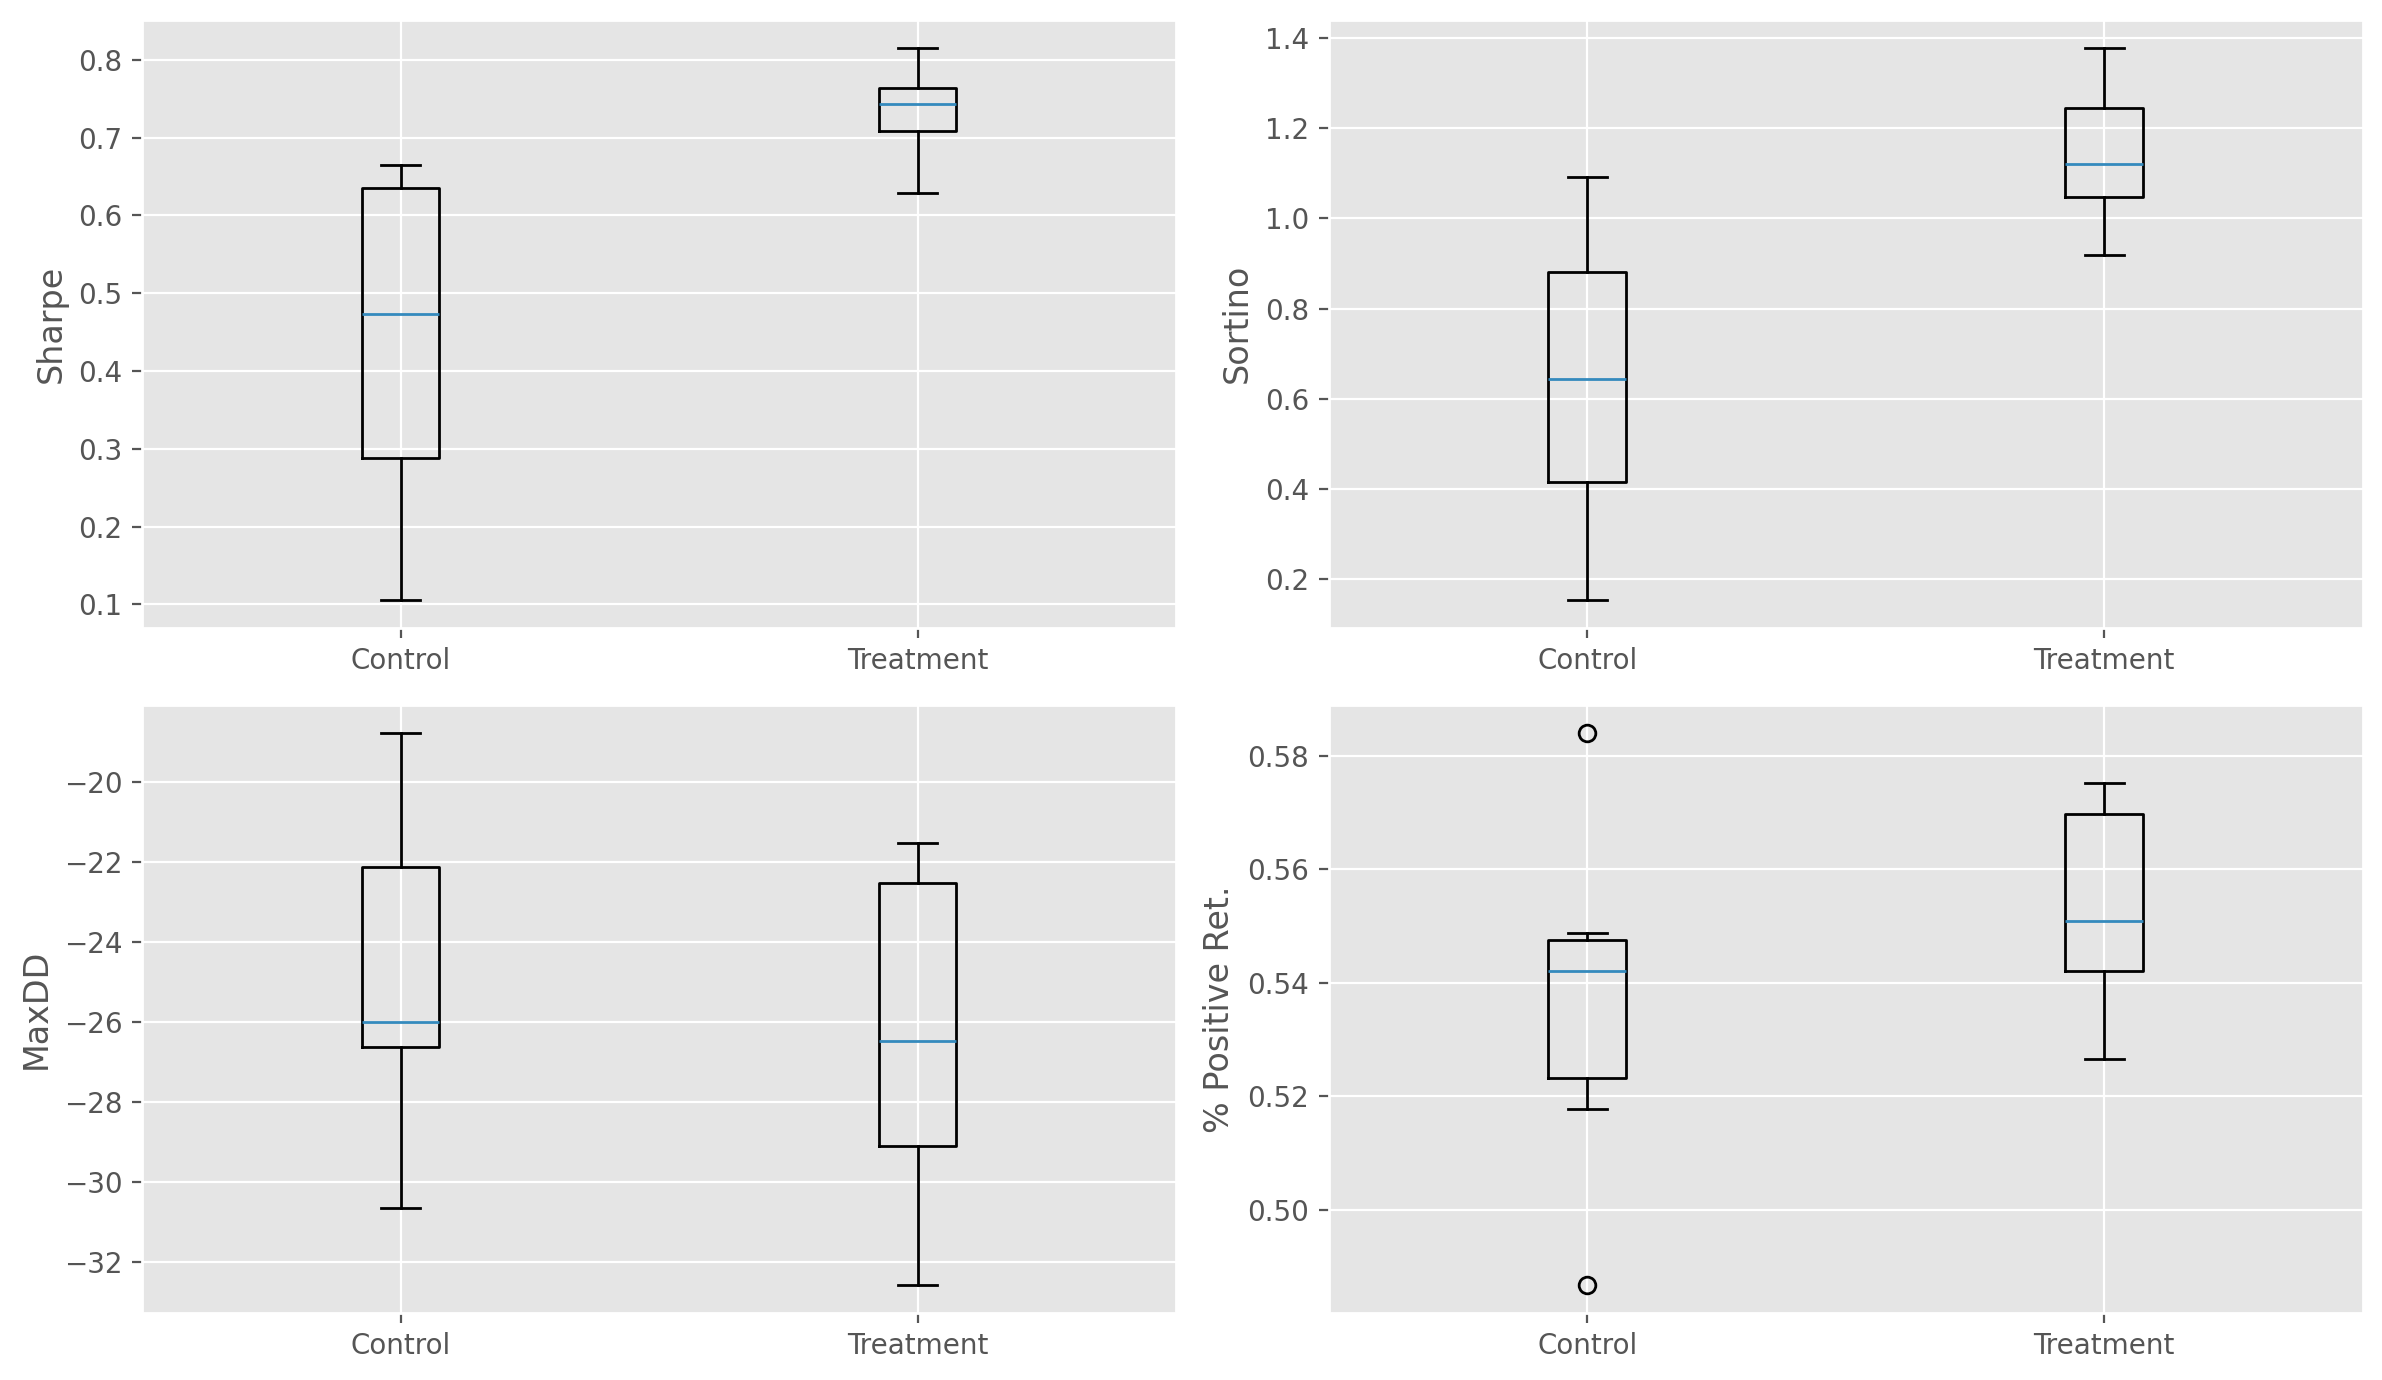

In [16]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = ["naive_lns_2_rand", "naive_lo_2_rand", "naive_lns_3_rand", "naive_lo_3_rand", "naive_lns_4_rand", "naive_lo_4_rand"]
treatment = ["naive_lns_2", "naive_lo_2", "naive_lns_3", "naive_lo_3", "naive_lns_4", "naive_lo_4"]

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.ravel()

for i, metric_name in enumerate(metric_names):
   metric_values = voladj_returns.apply(lambda x: compute_summary_statistics(torch.tensor(x.values))[metric_name], axis=0)
   data = [metric_values[control], metric_values[treatment]]
   
   axes[i].boxplot(data, tick_labels=['Control', 'Treatment'])
   # axes[i].set_title(metric_name)
   axes[i].set_ylabel(metric_name)
   axes[i].grid(True)

plt.tight_layout()
plt.show()

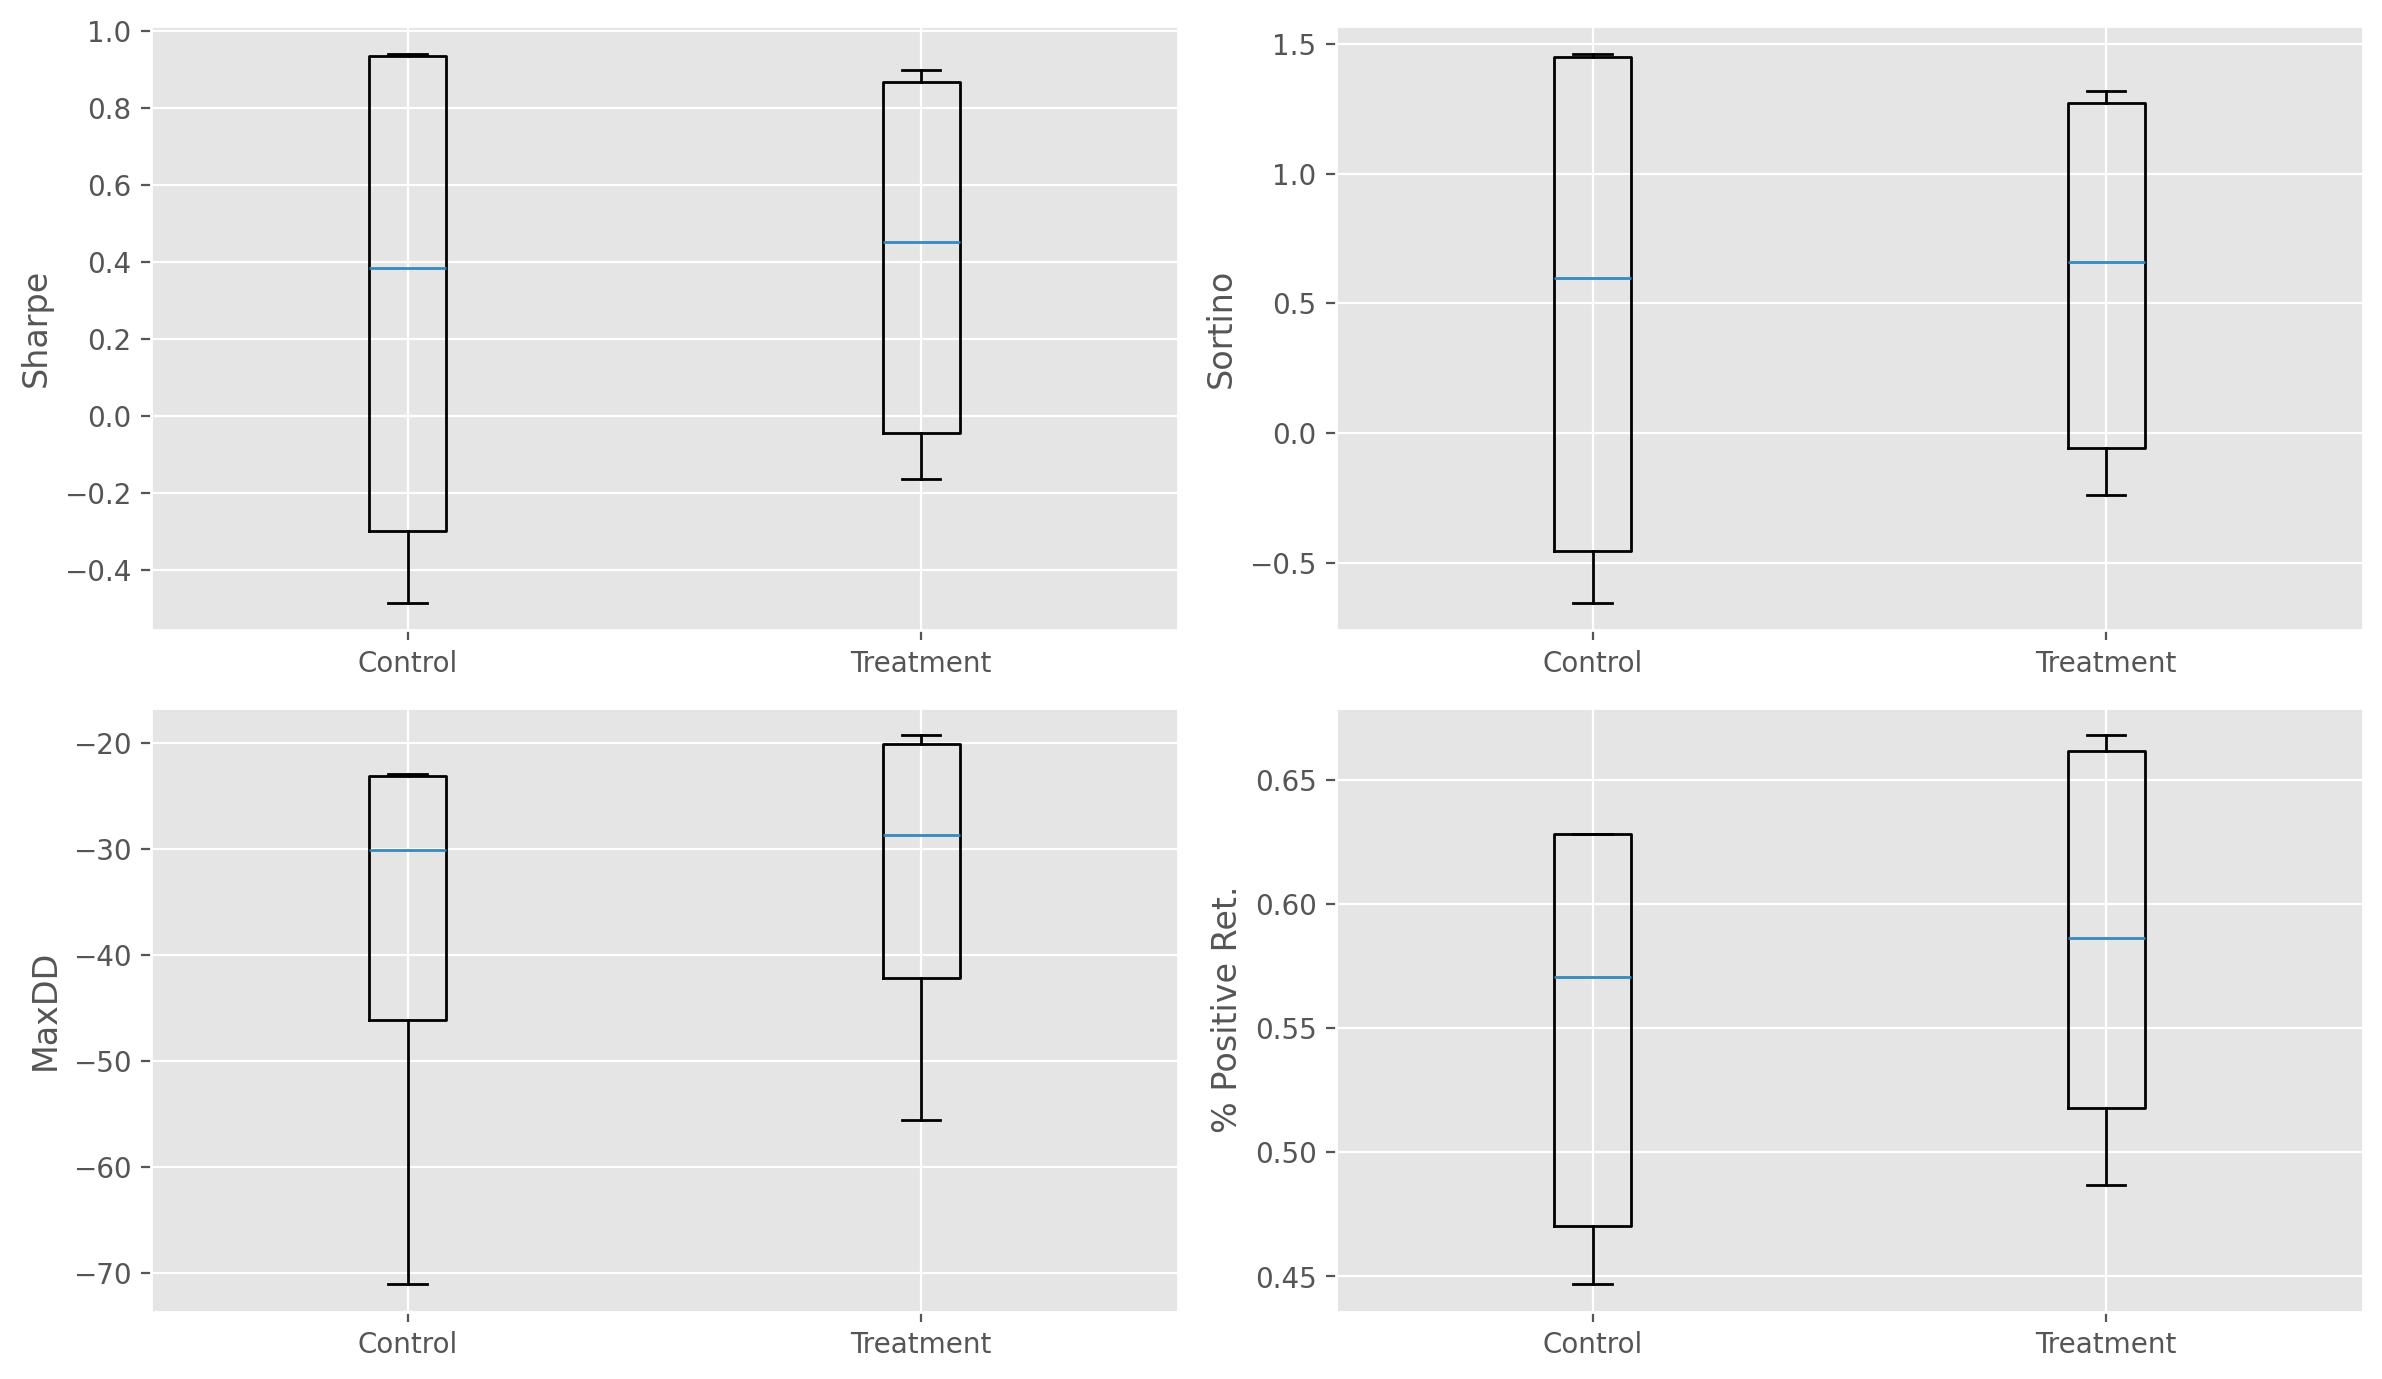

In [14]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = ["mvo_lns_2", "mvo_lo_2", "mvo_lns_3", "mvo_lo_3", "mvo_lns_4", "mvo_lo_4"]
treatment = ["bl_lns_2", "bl_lo_2", "bl_lns_3", "bl_lo_3", "bl_lns_4", "bl_lo_4"]

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.ravel()

for i, metric_name in enumerate(metric_names):
   metric_values = voladj_returns.apply(lambda x: compute_summary_statistics(torch.tensor(x.values))[metric_name], axis=0)
   data = [metric_values[control], metric_values[treatment]]
   
   axes[i].boxplot(data, tick_labels=['Control', 'Treatment'])
   # axes[i].set_title(metric_name)
   axes[i].set_ylabel(metric_name)
   axes[i].grid(True)

plt.tight_layout()
plt.show()

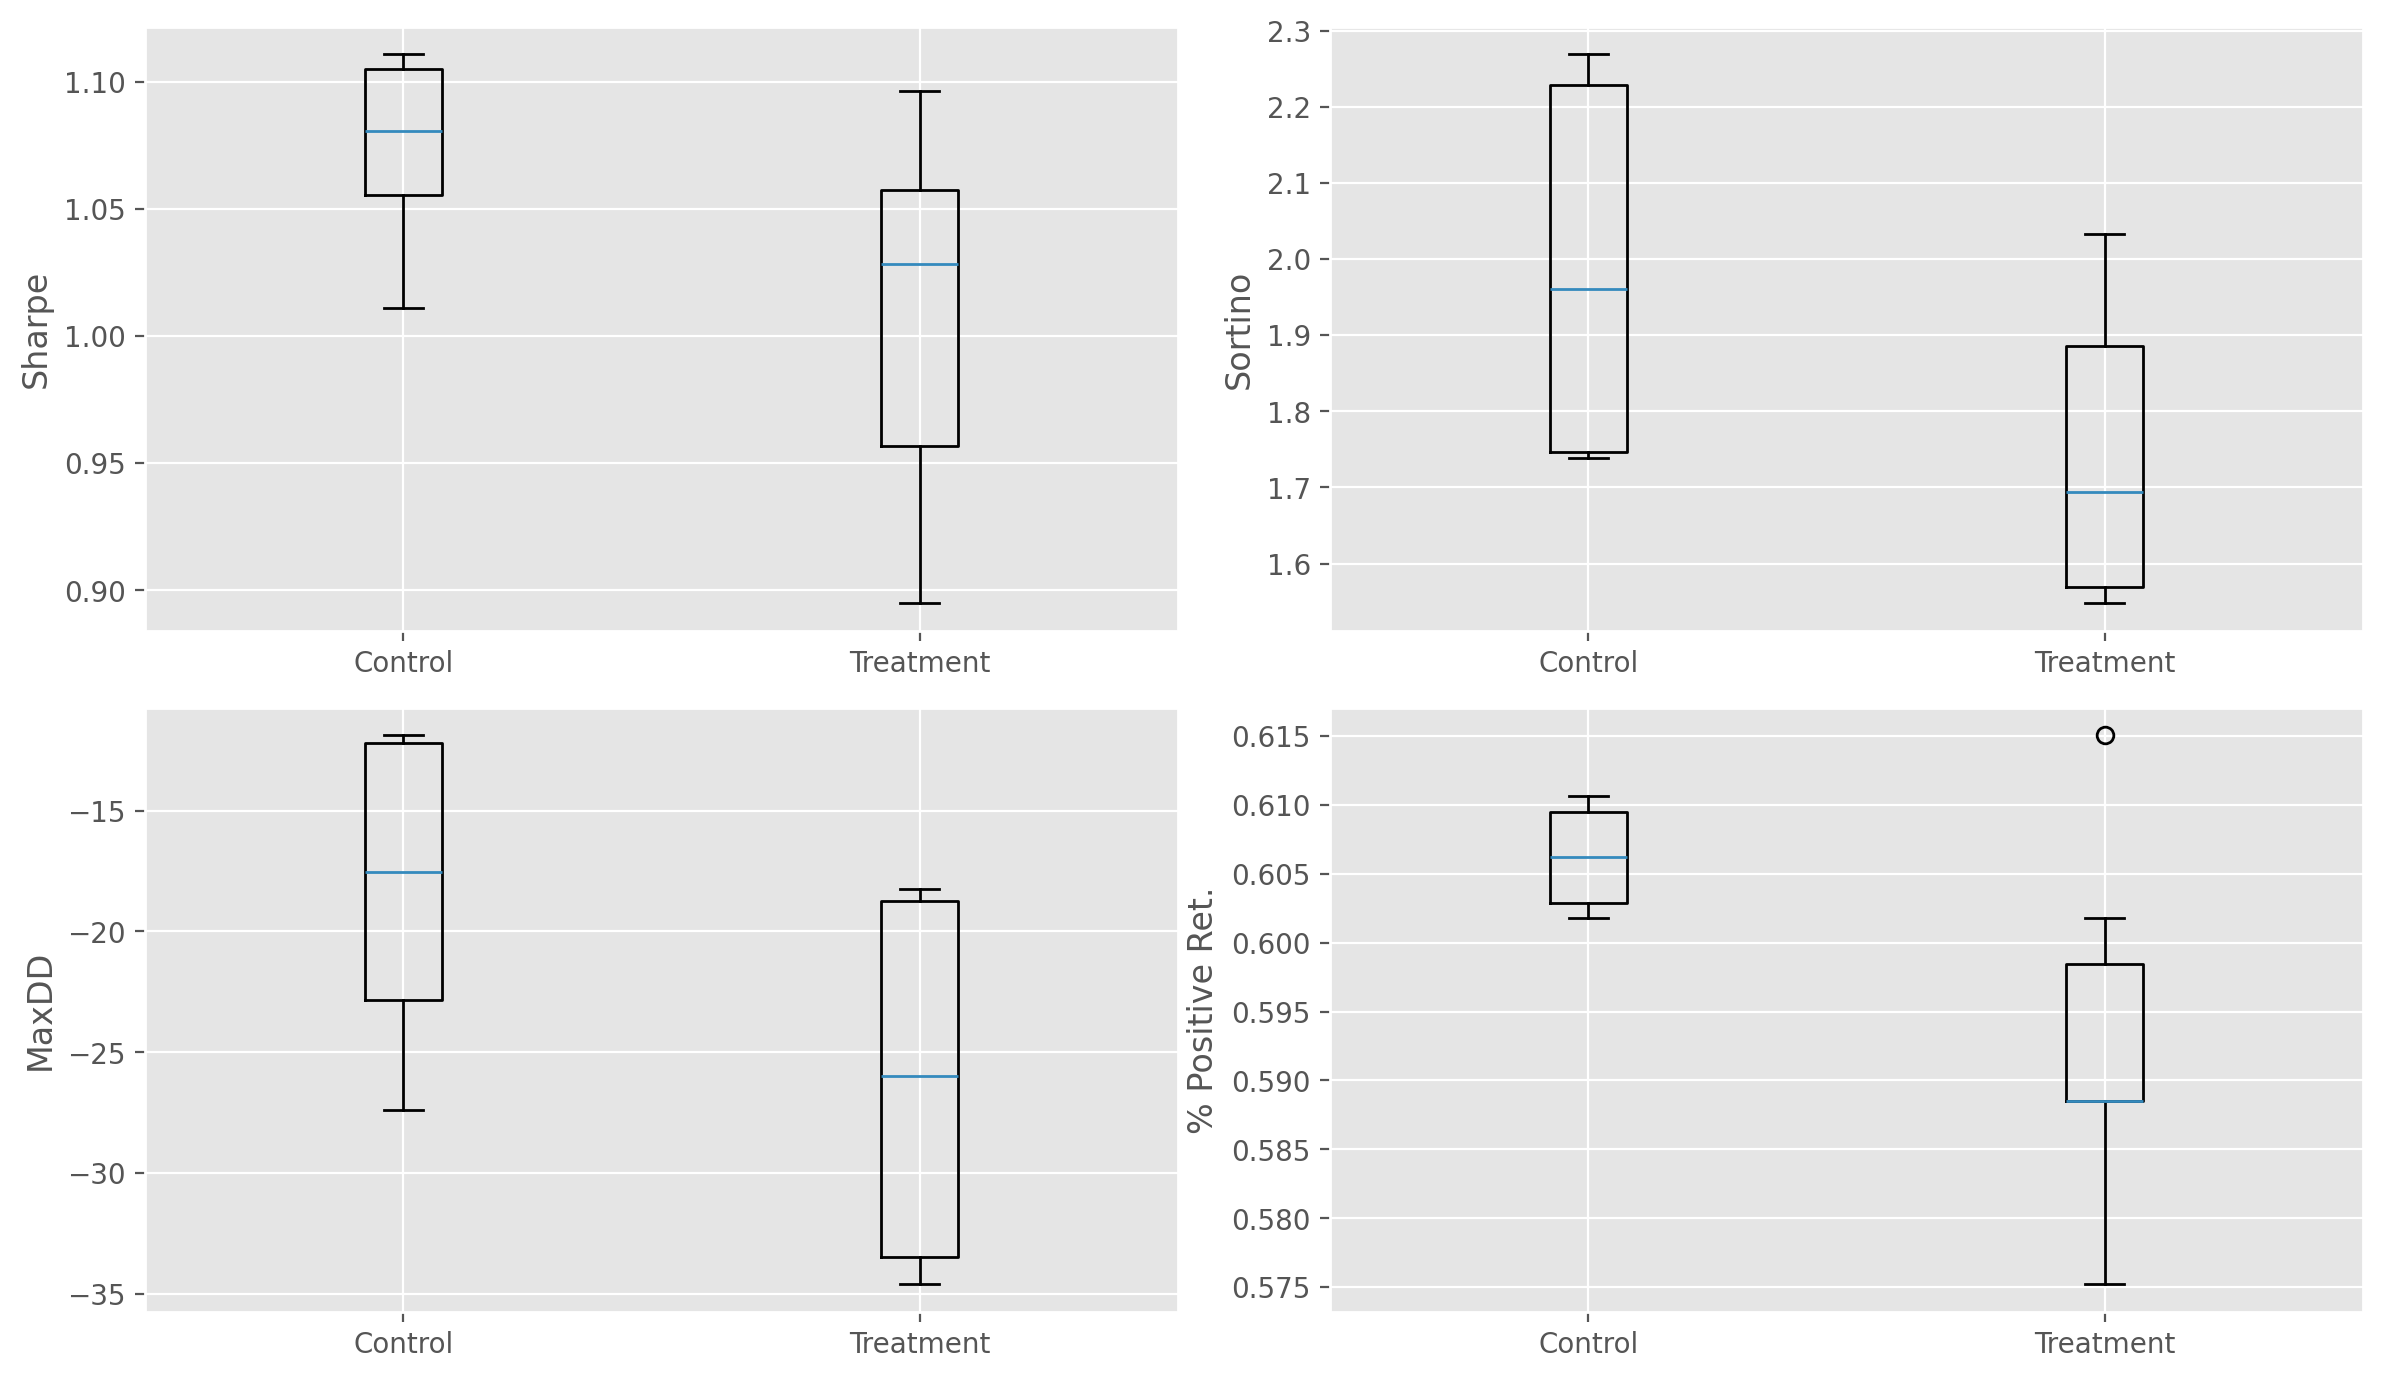

In [15]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = ["linear-ridge_lns_2_rand", "linear-ridge_lo_2_rand", "linear-ridge_lns_3_rand", "linear-ridge_lo_3_rand", "linear-ridge_lns_4_rand", "linear-ridge_lo_4_rand"]
treatment = ["linear-ridge_lns_2", "linear-ridge_lo_2", "linear-ridge_lns_3", "linear-ridge_lo_3", "linear-ridge_lns_4", "linear-ridge_lo_4"]

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.ravel()

for i, metric_name in enumerate(metric_names):
   metric_values = voladj_returns.apply(lambda x: compute_summary_statistics(torch.tensor(x.values))[metric_name], axis=0)
   data = [metric_values[control], metric_values[treatment]]
   
   axes[i].boxplot(data, tick_labels=['Control', 'Treatment'])
   # axes[i].set_title(metric_name)
   axes[i].set_ylabel(metric_name)
   axes[i].grid(True)

plt.tight_layout()
plt.show()